In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
from statistics import mean 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=False, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
train_labelled, train_unlabelled = torch.utils.data.random_split(trainloader.dataset, (250, 59750))
train_l_loader = torch.utils.data.DataLoader(train_labelled, batch_size=4,
                                         shuffle=False, num_workers=2)
train_ul_loader = torch.utils.data.DataLoader(train_unlabelled, batch_size=956,
                                         shuffle=False, num_workers=2)

#####################
classes = ('one', 'two', 'three', 'four',
           'five', 'six', 'seven', 'eight', 'nine', 'ten')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  six   one  five   two


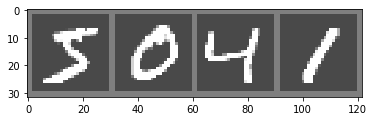

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(2304, 60),
            nn.ReLU(inplace=True),
            nn.Linear(60, 60),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(60, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x
net = CNN()
net = net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))

In [0]:
import torch.optim as optim

criterion_ce = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
from torch.distributions import Categorical
class HLoss(nn.Module):
    def __init__(self):
        super(HLoss, self).__init__()

    def forward(self, x,L):
        b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
        #b = Categorical(probs = x).entropy()
        #b = x*torch.log(x)
        #print(b)
        b = -1.0 * b.sum()/L
        return b
        
criterion_e = HLoss()


In [0]:
#from utils import to_gpu, parse_layers_from_file, augment
from torch.autograd import Variable
for epoch in range(500):
 running_loss = 0.0
 for batch_idx, (labeled, unlabeled) in enumerate(zip(train_l_loader, train_ul_loader)):
        
        data, target = labeled
        data_unlabeled, _ = unlabeled
        data, target = data.cuda(), target.cuda()
        data_unlabeled = data_unlabeled.cuda()
        optimizer.zero_grad()
        L = len(data_unlabeled)
        if epoch > -1:
        
          outputs_e = net(data_unlabeled)
          #outputs_e.detach()
        
          loss_e = criterion_e(outputs_e,L)
          #loss_e.detach()
        
        else:
          loss_e = 0
       
        
        outputs = net(data)
        loss_ce = criterion_ce(outputs, target)
        
        loss = loss_e + loss_ce
        #print("loss ce", loss)
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        if  batch_idx % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')


[1,    20] loss: 4.598
[1,    40] loss: 4.603
[1,    60] loss: 4.595
[2,    20] loss: 4.539
[2,    40] loss: 4.485
[2,    60] loss: 4.465
[3,    20] loss: 4.168
[3,    40] loss: 4.099
[3,    60] loss: 4.078
[4,    20] loss: 3.716
[4,    40] loss: 3.468
[4,    60] loss: 3.094
[5,    20] loss: 2.426
[5,    40] loss: 1.856
[5,    60] loss: 1.638
[6,    20] loss: 1.330
[6,    40] loss: 1.151
[6,    60] loss: 0.695
[7,    20] loss: 0.929
[7,    40] loss: 0.649
[7,    60] loss: 0.557
[8,    20] loss: 0.534
[8,    40] loss: 0.779
[8,    60] loss: 0.477
[9,    20] loss: 0.414
[9,    40] loss: 0.422
[9,    60] loss: 0.253
[10,    20] loss: 0.235
[10,    40] loss: 0.202
[10,    60] loss: 0.264
[11,    20] loss: 0.154
[11,    40] loss: 0.129
[11,    60] loss: 0.202
[12,    20] loss: 0.435
[12,    40] loss: 0.396
[12,    60] loss: 0.312
[13,    20] loss: 0.459
[13,    40] loss: 0.332
[13,    60] loss: 0.241
[14,    20] loss: 0.174
[14,    40] loss: 0.284
[14,    60] loss: 0.103
[15,    20] loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  eight three   two   one


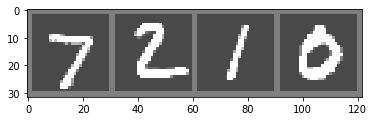

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images)

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  eight three   two   one


In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
cm = []
count = 0
class_names=[0,1,2,3,4,5,6,7,8,9]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()  
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        if count == 0:
          c_m = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=class_names)
          
        else:
          c_m += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=class_names)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        count+=1
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cm = []
count = 0
class_names=[0,1,2,3,4,5,6,7,8,9]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if count == 0:
          c_m = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=class_names)
          
        else:
          c_m += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=class_names)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        count += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   one : 97 %
Accuracy of   two : 97 %
Accuracy of three : 96 %
Accuracy of  four : 97 %
Accuracy of  five : 97 %
Accuracy of   six : 96 %
Accuracy of seven : 95 %
Accuracy of eight : 95 %
Accuracy of  nine : 92 %
Accuracy of   ten : 94 %


Confusion matrix, without normalization
[[ 960    0    1    3    0    1    7    1    3    4]
 [   0 1108    6    3    1    4    1    2   10    0]
 [   3    0  996    9    3    0    0   14    7    0]
 [   0    0    6  982    0   10    0    9    2    1]
 [   0    2    2    0  959    1    4    1    0   13]
 [   4    0    0   11    2  862    5    0    8    0]
 [  17    2    2    0   12    5  918    0    2    0]
 [   0    0   33    1    1    2    0  982    2    7]
 [  21    1    7    3    1    2   10    3  900   26]
 [   6    1    1    5   11   16    0   14    3  952]]


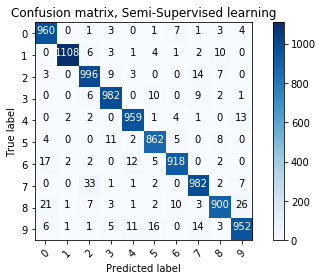

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(c_m, classes=class_names,
                      title='Confusion matrix, Semi-Supervised learning')